Trabalho de RN

Aluno: Flávio Amorim

Número: 211100510

Turma: 2021.1


1) **Transfer learning é quando um modelo treinado em um conjunto de dados é utilizado para resolver um novo problema com dados diferentes daqueles que ele foi treinado.**

2) **Introdução:**



*   Modelo recebido como base do trabalho apresentava a seguinte performace:

  Loss: 0.08588726818561554      
  Accuracy: 0.9749000072479248


*   Modelo otimizado (ainda com SGD) apresentou a seguinte performance:

  Loss: 0.03293868899345398
  
  Accuracy: 0.9890999794006348

**Melhorias aplicadas ao modelo recebido como base do trabalho (ainda com SGD):**
*   Criado uma estrutira de grid search para avaliar vários hiperparametros
*   Acrescentada a camada: layers.Dense(128, activation = 'relu')
*   Reduzido o dropout para: layers.Dropout(0.2)
*   Introduzida função de learning rate
*   Exibido as curvas de loss e acurácia para cada modelo treinado
*   Introduzida Funçào callback
*   Todos modelos treinados são salvos
*   Dataframe criado com as informações de hiperparametros e performance de cada modelo treinado
*   De acordo com este dataframe acima, o melhor modelo é carregado para uma nova uma predição na base de teste
*   Plotado algumas figuras resultantes da predição.


O melhor foi com 128 de batch, 60 épocas, validação em 10% e drop out em 0.2.

Ele não apresentou overfittimg e foi o de menor loss e maior acurácia.



obs: Com a estrutura de grid search, diversos cenários foram testados, mas nesse notebook estão apenas alguns.

## Setup

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import time

In [2]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint            # criados os checkpoints

In [3]:
import tensorflow                                      # trabalhando com tensorflow # 2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
print("TensorFlow version:", tensorflow.__version__)

TensorFlow version: 2.8.0


## Prepare the data

In [4]:
# leitura dos dados
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# verificando o formato
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
# criando um vetor com o nome das 10 classes
class_names = ['Zero','Um', 'Dois', 'Tres', 'Quatro', 'Cinco', 
               'Seis', 'Sete', 'Oito', 'Nove', 'Dez']

# Data Visualization

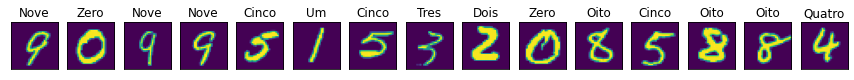

In [6]:
# exibido randomicamente 15 imagens
# dados de treinamento

plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    #plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_train))
    plt.imshow(x_train[j].reshape((28,28)))
    label_index = int(y_train[j])
    plt.title(class_names[label_index])
plt.show()

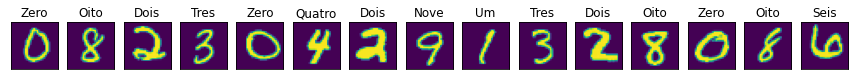

In [7]:
# exibido randomicamente 15 imagens
# dados de teste

plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_test))
    plt.imshow(x_test[j].reshape((28,28)))
    label_index = int(y_test[j])
    plt.title(class_names[label_index])
plt.show()

# Pre-processamento

In [8]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)               # imagens de 28 x 28 e profundidade 1 


# Scale images to the [0, 1] range      
x_train = x_train.astype("float32") / 255    # transformando para float e normalizando
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
# convert class vectors (labels) to binary class matrices (dim = 10 classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape,y_test.shape)


(60000, 10) (10000, 10)


# Funcoes auxiliares

In [10]:
# create a list of configs to try
def model_configs():
  # define scope of configs
  n_batch_size = [128,256]                  # foram feitos testes com 128 e 256
  n_epochs = [15,60]                        # foram feitos testes com 15, 25, 50, 60, 75 e 100
  n_validation_split = [0.1,0.2]            # foram feitos testes com 0.1, 0.15, 0.2 e 0.3
  configs = list()                          # criado a lista com as combinações dos hiperparâmetros
  for i in n_batch_size:
    for j in n_epochs:
      for k in n_validation_split:
        cfg = [i, j, k]
        configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs


In [11]:
# plota a curva de loss e acurácia para teste e validação
def plota_figuras(history):
  fig = plt.figure(figsize=(10, 10))
  
  plt.subplot(2, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.title('Loss Function')

  plt.subplot(2, 2, 2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.legend()
  plt.title('Accuracy')
  fig.savefig("fig01.png")

# Funcoes principais

Criada uma estrutura de grid search para executar vários treinamentos com diferentes modelos

In [12]:
# cria o modelo, o otimizador, compila e faz o fit
def modelfit(cfg):
  #print(cfg)
  (n_batch_size, n_epochs, n_validation_split) = cfg

  model = keras.Sequential(
    [
      keras.Input(shape=input_shape),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation = 'relu'),
      layers.Dropout(0.2),  #0,2 testar era 0.5
      layers.Dense(num_classes, activation="softmax"),
    ]
  )

  model.summary()

  sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=False)  #0.9
  model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

  filepath = "checkpoint-{epoch}.h5"  # {epoch}
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  history = model.fit(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs, validation_split=n_validation_split, callbacks=callbacks_list ) 

  return(history,model)

In [13]:
# chama a funcao que cria o modelo e executa o fit
# executa o evaluate e depois salva o modelo
# exibe na tela os scores
def fit_evaluate_model(cfg,id_modelo):

  start = time.time()

  print('-------------------------new hiperparameter iteration---------------------------------------------')
  history,model = modelfit(cfg)

  end = time.time()
  plota_figuras(history)
  score = model.evaluate(x_test, y_test, verbose=0)
  print('\nSummary:')
  print('\nModelo: ',str(cfg))
  print('\nTime to Fit: ', end - start)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  print("Score:", score)
  filepath = f"model-{id_modelo}.h5"
  print("Salvando o modelo: ",filepath)
  model.save(filepath,overwrite=True,include_optimizer=True)  # creates a HDF5 file 'my_model.h5'
  print('\n\n\n')
  return (score[0],score[1])

In [14]:
# executa o processamento para cada elemento da lista de hiperparametros
# retorna uma lista com os scores de cada modelo criado
def grid_search(cfg_list):
  scores = [fit_evaluate_model(cfg,id_modelo) for id_modelo,cfg in enumerate(cfg_list)]  # função executada para cada elemento da lista de hiperparâmetros
  return scores

# MAIN

In [15]:
cfg_list = model_configs()
print('Configs: \n',cfg_list)

Total configs: 8
Configs: 
 [[128, 15, 0.1], [128, 15, 0.2], [128, 60, 0.1], [128, 60, 0.2], [256, 15, 0.1], [256, 15, 0.2], [256, 60, 0.1], [256, 60, 0.2]]


-------------------------new hiperparameter iteration---------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                       

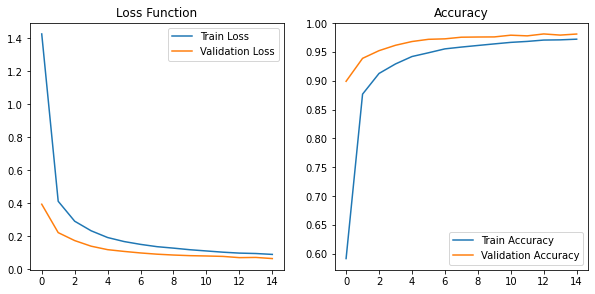

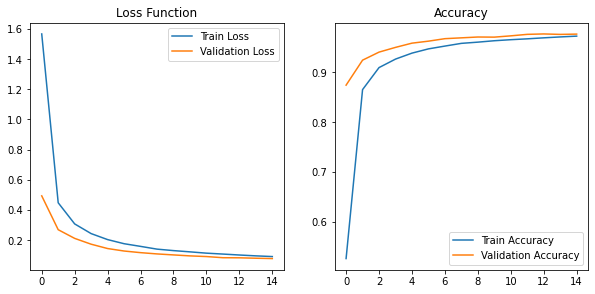

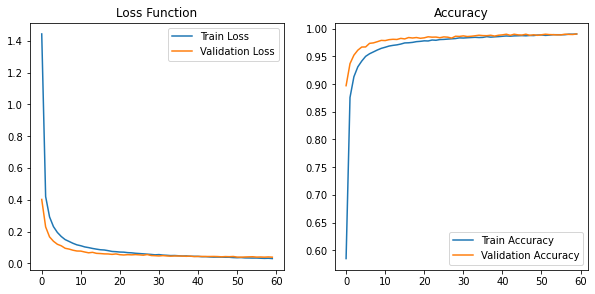

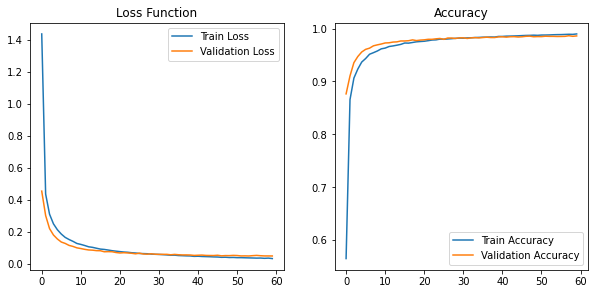

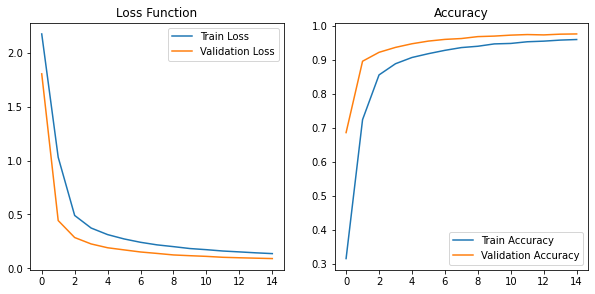

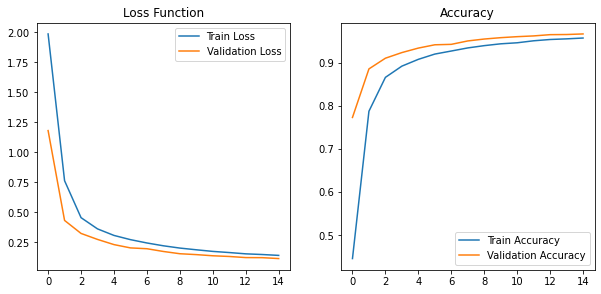

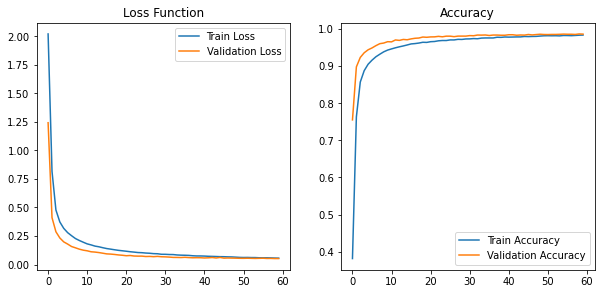

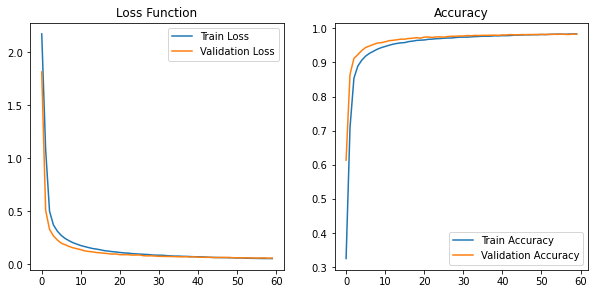

In [16]:
# executa o modelo para a lista de hiperparâmetros definida em cfg_list
scores = grid_search(cfg_list)

In [17]:
# exibe a lista de acuracia ordenada pela maior (melhor)
sorted(scores, key=lambda tup: tup[0])

[(0.03293868899345398, 0.9890999794006348),
 (0.03397781401872635, 0.9887999892234802),
 (0.04553612694144249, 0.9854999780654907),
 (0.047169070690870285, 0.9850999712944031),
 (0.06412313133478165, 0.979200005531311),
 (0.06863174587488174, 0.9793999791145325),
 (0.0992383360862732, 0.9704999923706055),
 (0.10366635769605637, 0.9696999788284302)]

In [18]:
# cria um dataframe para registro do score de todos os modelos testados para futuro registro e comparação
import pandas as pd
lmodelo = []
lloss = []
laccuracy = []
lbatch_size = []                  # foram feitos testes com 128 e 256
lepochs = []                        # foram feitos testes com 15, 25, 50, 60, 75 e 100
lvalidation_split = [] 

dict = {}

for i in range(len(scores)):
  lmodelo.append(i)
  lloss.append(float(scores[i][0])) 
  laccuracy.append(float(scores[i][1]))
  lbatch_size .append(cfg_list[i][0])
  lepochs.append(cfg_list[i][1])
  lvalidation_split.append(cfg_list[i][2])
dict = {'Id Modelo':lmodelo,'Loss':lloss,'Accuracy':laccuracy,'Batch size':lbatch_size,'Epocs':lepochs,'Validation split':lvalidation_split}
df = pd.DataFrame(dict).sort_values(['Accuracy','Loss'],ascending=[False,True]).reset_index(drop=True)
df

,Id Modelo,Loss,Accuracy,Batch size,Epocs,Validation split
0,2,0.032939,0.9891,128,60,0.1
1,3,0.033978,0.9888,128,60,0.2
2,7,0.045536,0.9855,256,60,0.2
3,6,0.047169,0.9851,256,60,0.1
4,1,0.068632,0.9794,128,15,0.2
5,0,0.064123,0.9792,128,15,0.1
6,4,0.099238,0.9705,256,15,0.1
7,5,0.103666,0.9697,256,15,0.2


# Refazendo a predição para o conjunto de teste com o melhor modelo

In [19]:
# Carrega o melhor modelo (considerado o com maior acurácia e menor loss)
id_best_model = df.iloc[0,0]
filepath = f'model-{id_best_model}.h5'
best_model = tensorflow.keras.models.load_model(
    filepath, custom_objects=None, compile=True, options=None)

best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

# Predict e exibindo 15 registros aleatórios

In [20]:
y_predict = best_model.predict(x_test)

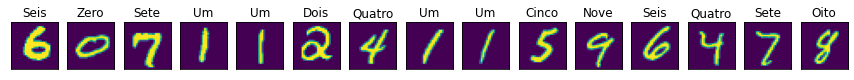

In [21]:
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    #plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_test))
    plt.imshow(x_test[j].reshape((28,28)))
    label_index = np.argmax(y_predict[j])     # argmax do elemento escolhido em y_predict
    plt.title(class_names[label_index])
plt.show()